# Part I: Define an RL Environment - Lawnmower Grid World

In the first part of this assignment, we focus on defining a grid-world reinforcement learning environment. This environment is modeled as a Markov Decision Process (MDP) and is designed according to the Gym standards.


In [1]:
!pip3 install gym


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt


## Define the Lawnmower Environment Class

In this step, we define the main class for our reinforcement learning environment, named `LawnmowerEnv`. 

- `__init__`: Initializes the environment, sets up the grid size, initial position of the agent, action and observation spaces, and initializes the grid with rewards and obstacles.
- `init_grid`: A helper method to initialize or reset the grid with batteries and rocks placed randomly.
- `step`: This method takes an action as input and returns the new state, reward, done (boolean indicating whether the episode has ended), and additional info. It implements the logic for the agent's movement and interaction with the environment.
- `reset`: Resets the environment to its initial state for a new episode.
- `render`: For visualization purposes, this method displays the current state of the environment, representing the grid, the agent's position, batteries, and rocks.


In [3]:

class LawnmowerEnv(gym.Env):
    def __init__(self, random_grid=True):
        super(LawnmowerEnv, self).__init__()
        
        self.grid_size = 4  # Define the size of the grid
        self.agent_pos = [0, 0]  # Agent starts at the top-left corner
        self.random_grid = random_grid  # Option to have a random or fixed grid
        self.max_steps = 10  # Maximum steps per episode
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # 4 actions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=1, 
                                            shape=(self.grid_size * self.grid_size,), 
                                            dtype=np.int64)

        # Initialize grid and rewards
        self.init_grid()

    def init_grid(self):
        self.grid = np.zeros((self.grid_size, self.grid_size))
        if self.random_grid:
            # Randomly place batteries and rocks
            num_items = self.grid_size
            for _ in range(num_items):
                battery_pos = np.random.choice(self.grid_size, 2)
                self.grid[battery_pos[0], battery_pos[1]] = 5
                rock_pos = np.random.choice(self.grid_size, 2)
                while np.array_equal(rock_pos, battery_pos):
                    rock_pos = np.random.choice(self.grid_size, 2)
                self.grid[rock_pos[0], rock_pos[1]] = -5
        else:
            pass

    def step(self, action):
        self.current_step += 1

        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.grid_size - 1:
            self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] < self.grid_size - 1:
            self.agent_pos[1] += 1
        elif action == 3 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1

        reward = self.grid[self.agent_pos[0], self.agent_pos[1]]
        done = self.current_step >= self.max_steps 

        self.grid[self.agent_pos[0], self.agent_pos[1]] = 0

        info = {}  
        return self.agent_pos, reward, done, info

    def reset(self):
        self.agent_pos = [0, 0]
        self.current_step = 0
        if self.random_grid:
            self.init_grid()  # Reinitialize the grid for random setup
        return self.agent_pos

    def render(self, mode='human'):
        grid_copy = np.copy(self.grid)
        grid_copy[self.agent_pos[0], self.agent_pos[1]] = 10  # Representing the agent
        plt.imshow(grid_copy, cmap='hot', interpolation='nearest')
        plt.show()



## Testing the Environment


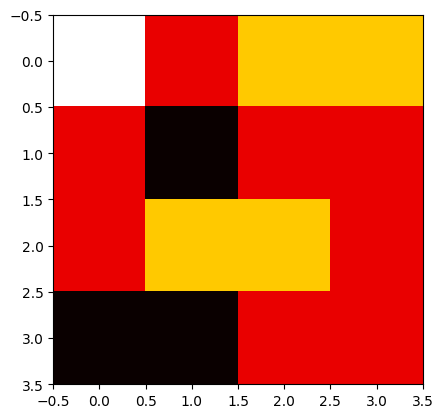

State: [0, 0], Action: 3, Reward: -5.0


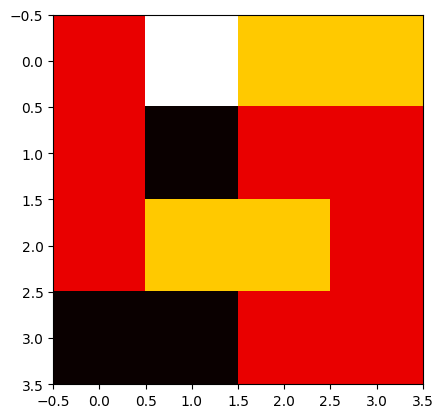

State: [0, 1], Action: 2, Reward: 0.0


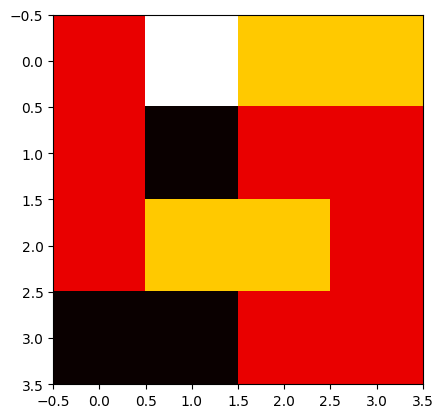

State: [0, 1], Action: 0, Reward: 0.0


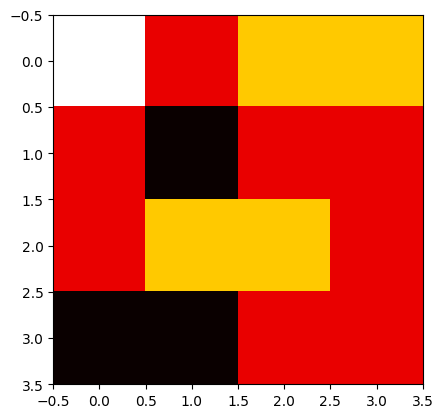

State: [0, 0], Action: 3, Reward: 0.0


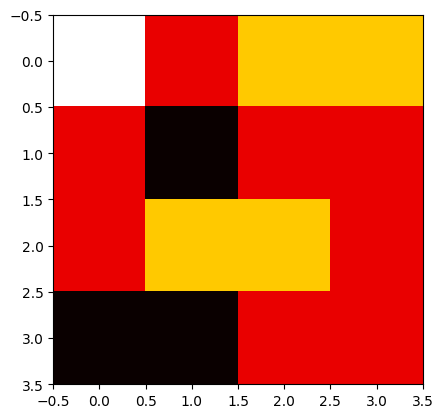

State: [0, 0], Action: 0, Reward: 0.0


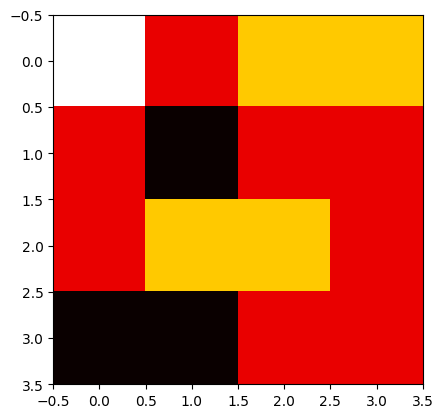

State: [0, 0], Action: 0, Reward: 0.0


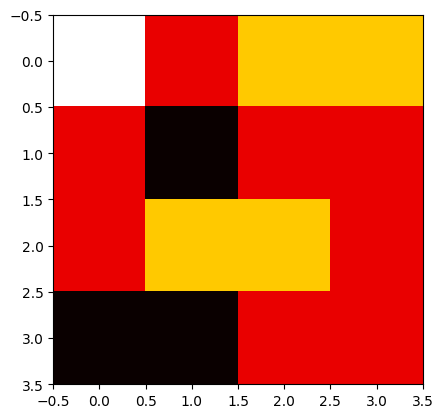

State: [0, 0], Action: 3, Reward: 0.0


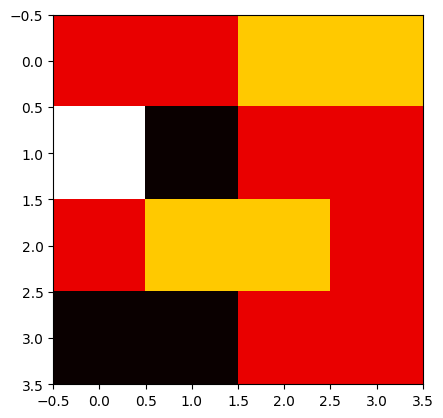

State: [1, 0], Action: 1, Reward: 0.0


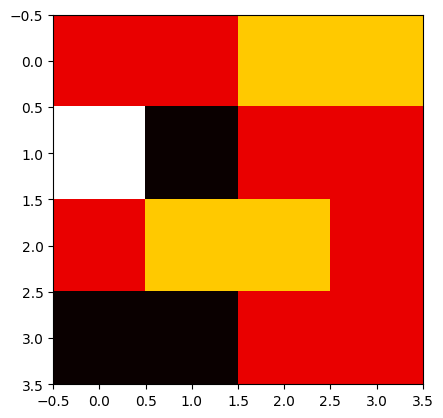

State: [1, 0], Action: 3, Reward: 0.0


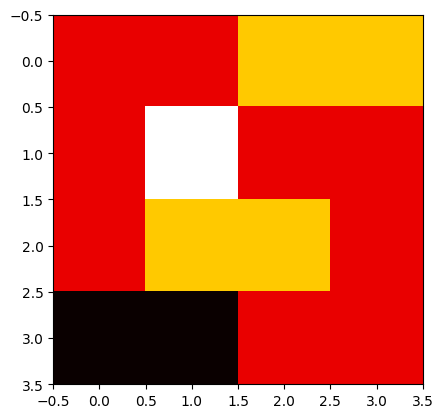

State: [1, 1], Action: 2, Reward: -5.0


In [4]:

env = LawnmowerEnv(random_grid=True)  # Change to False for a fixed grid

for _ in range(10):
    action = env.action_space.sample()  # Random action
    state, reward, done, _ = env.step(action)
    env.render()  # Visualize the grid
    print(f"State: {state}, Action: {action}, Reward: {reward}")
    if done:
        env.reset()


## Part II: Implement SARSA [40 pts]

In this part, we implement the SARSA (State-Action-Reward-State-Action) algorithm and apply it to solve the environment defined in Part 1. SARSA is an on-policy reinforcement learning algorithm where the agent updates its Q-values based on the current state, action, reward, and next state-action pair.

In [5]:
# Initialize Q-table
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))

In [6]:
# Print the initial Q-table
print("Initial Q-table:")
print(q_table)



Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [7]:
# SARSA parameters
learning_rate = 0.1
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.005
total_episodes = 1000
max_steps = 100



In [8]:
# Initialize history lists for plotting
total_rewards_history = []
epsilon_history = []

# Learning loop
for episode in range(total_episodes):
    state = env.reset()
    state_index = np.ravel_multi_index(state, (env.grid_size, env.grid_size))  # Convert 2D state to 1D index

    step = 0
    done = False
    total_rewards = 0

    # Choose an action a in the current world state (s)
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table[state_index, :])

    while not done and step < max_steps:
        new_state, reward, done, info = env.step(action)
        new_state_index = np.ravel_multi_index(new_state, (env.grid_size, env.grid_size))

        new_action = np.argmax(q_table[new_state_index, :]) if np.random.uniform(0, 1) > epsilon else env.action_space.sample()

        # Update Q(s, a)
        q_table[state_index, action] = q_table[state_index, action] + learning_rate * (reward + gamma * q_table[new_state_index, new_action] - q_table[state_index, action])

        total_rewards += reward

        # Update state and action
        state_index = new_state_index
        action = new_action

        step += 1

    # Reduce epsilon (exploration rate) with decay
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # Append total rewards and epsilon value to the history lists after each episode
    total_rewards_history.append(total_rewards)
    epsilon_history.append(epsilon)



In [9]:
# Print the trained Q-table
print("Trained Q-table:")
print(q_table)



Trained Q-table:
[[-3.16347266e-01 -1.35193066e+00 -1.23327307e+00 -1.08160149e+00]
 [-1.97055341e-02 -1.10294114e-01 -2.81794577e-01 -3.00349032e-01]
 [ 1.93734221e-02 -3.98823448e-01 -4.82385728e-01  6.88458625e-02]
 [ 1.21751631e-01  4.53784692e-01  1.21989449e-01  4.19786452e-01]
 [-3.19892557e-01 -1.00266164e+00 -2.68711150e-01 -1.10393015e-01]
 [ 3.88835722e-02 -1.69572907e-01 -3.37407085e-01 -1.26787146e-01]
 [-2.83473929e-01 -7.15952283e-01 -9.94024069e-01 -7.24768714e-01]
 [-1.68248763e-01 -1.97090609e+00 -5.99756814e-02 -7.59990416e-02]
 [ 5.67448824e-01  5.03686355e-01  2.23864419e-01  3.82708441e-01]
 [ 4.89140986e-01  5.68300987e-02  9.90778637e-02 -2.45083908e-01]
 [-1.50938587e-01 -6.33361518e-01 -5.87692299e-01 -5.64216069e-01]
 [-7.67142145e-02  5.00000000e-02 -3.53721044e-02  1.16984707e-01]
 [ 3.53068654e-01  2.37593981e-03  0.00000000e+00  1.12544517e-04]
 [ 9.82255466e-02  0.00000000e+00  2.25339891e-01 -4.72951599e-01]
 [ 6.52094815e-02  4.45387521e-02  0.00000000

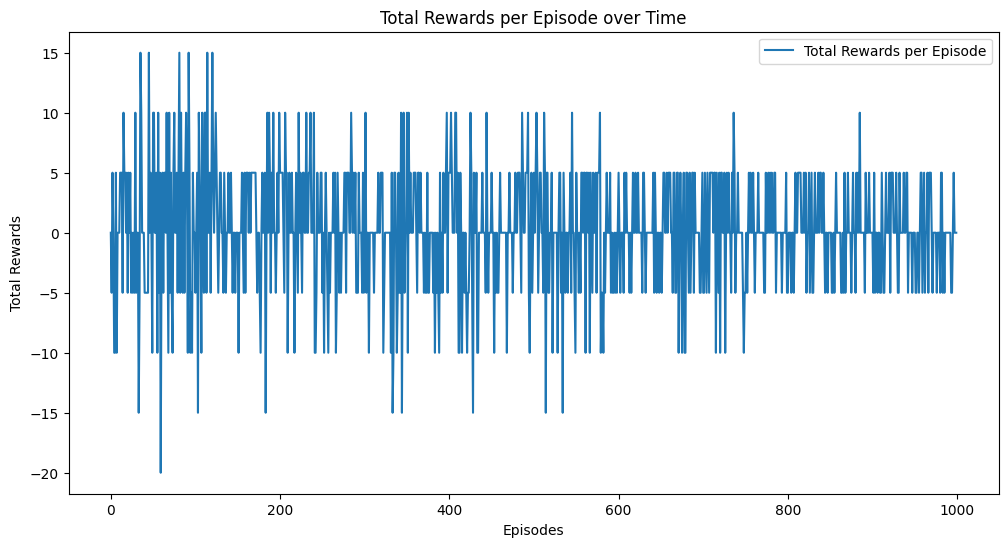

In [10]:
# Plot Total Rewards per Episode
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_history, label='Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards per Episode over Time')
plt.legend()
plt.show()



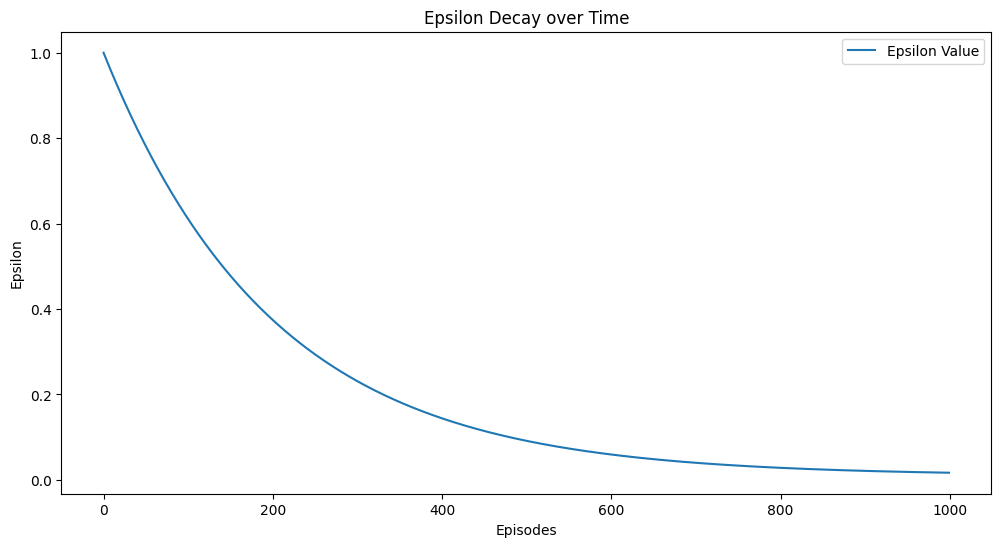

In [11]:
# Plot Epsilon Decay
plt.figure(figsize=(12, 6))
plt.plot(epsilon_history, label='Epsilon Value')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Time')
plt.legend()
plt.show()

EPISODE  0
Score:  0.0


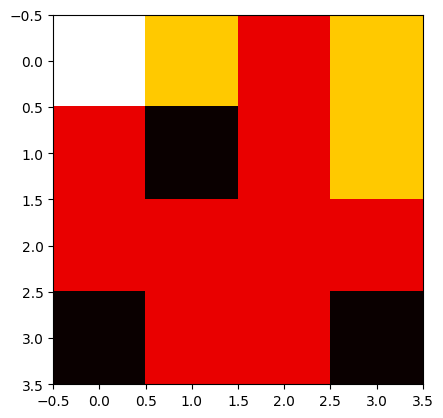

EPISODE  1
Score:  0.0


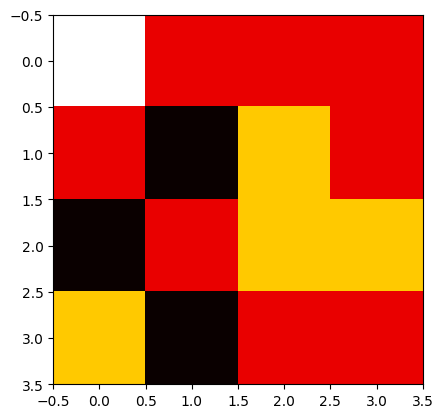

EPISODE  2
Score:  5.0


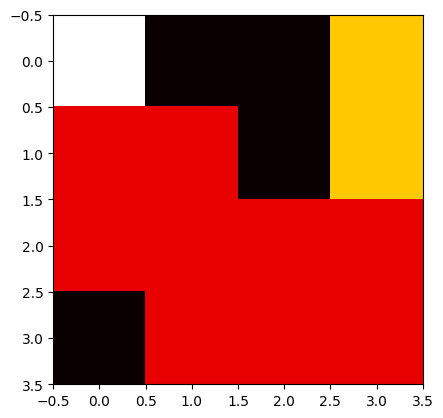

EPISODE  3
Score:  0.0


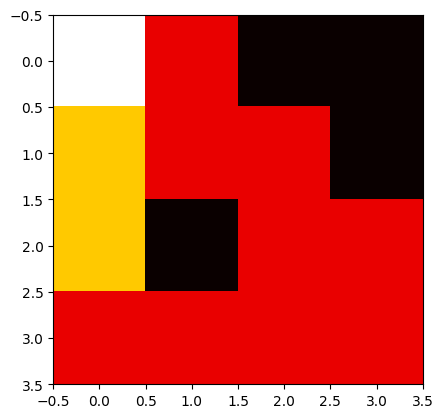

EPISODE  4
Score:  0.0


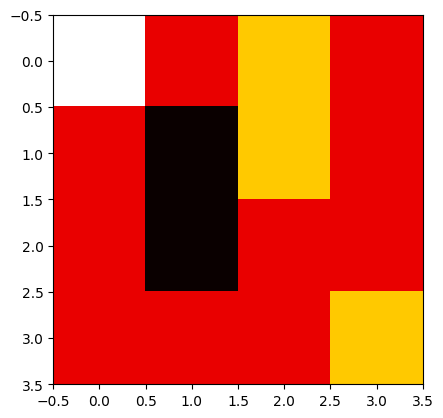

EPISODE  5
Score:  5.0


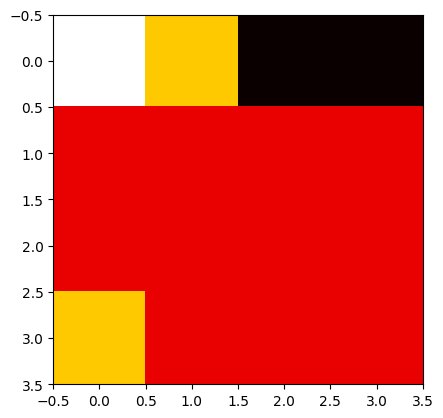

EPISODE  6
Score:  0.0


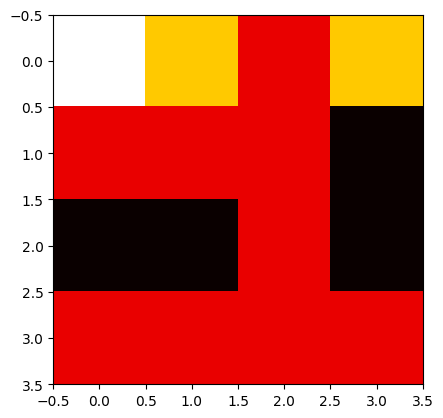

EPISODE  7
Score:  0.0


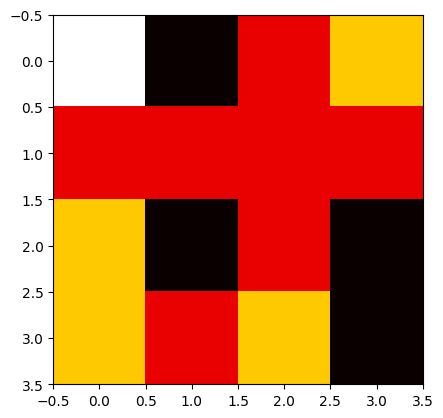

EPISODE  8
Score:  5.0


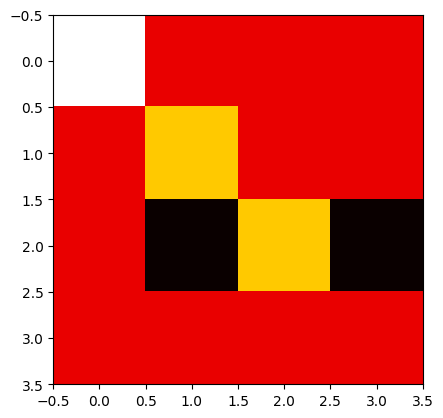

EPISODE  9
Score:  0.0


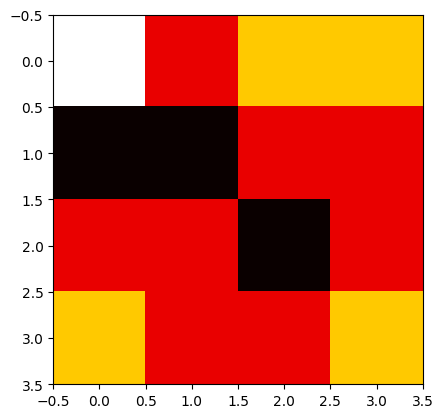

In [12]:
# Evaluation loop
for episode in range(10):
    state = env.reset()
    state = np.ravel_multi_index(state, (env.grid_size, env.grid_size))
    done = False
    total_rewards = 0

    print("EPISODE ", episode)

    for step in range(max_steps):
        action = np.argmax(q_table[state, :])
        new_state, reward, done, info = env.step(action)
        new_state = np.ravel_multi_index(new_state, (env.grid_size, env.grid_size))

        total_rewards += reward
        state = new_state

        if done:
            break

    print("Score: ", total_rewards)
    plt.figure()
    env.render()
    plt.close()

env.close()


Running SARSA with γ = 0.8 and Decay Rate = 0.005


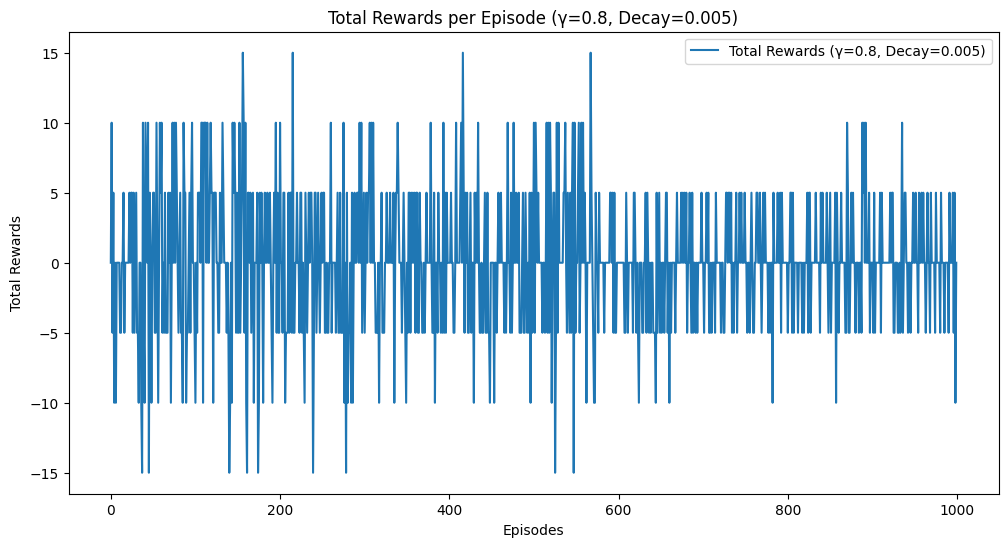

Running SARSA with γ = 0.8 and Decay Rate = 0.01


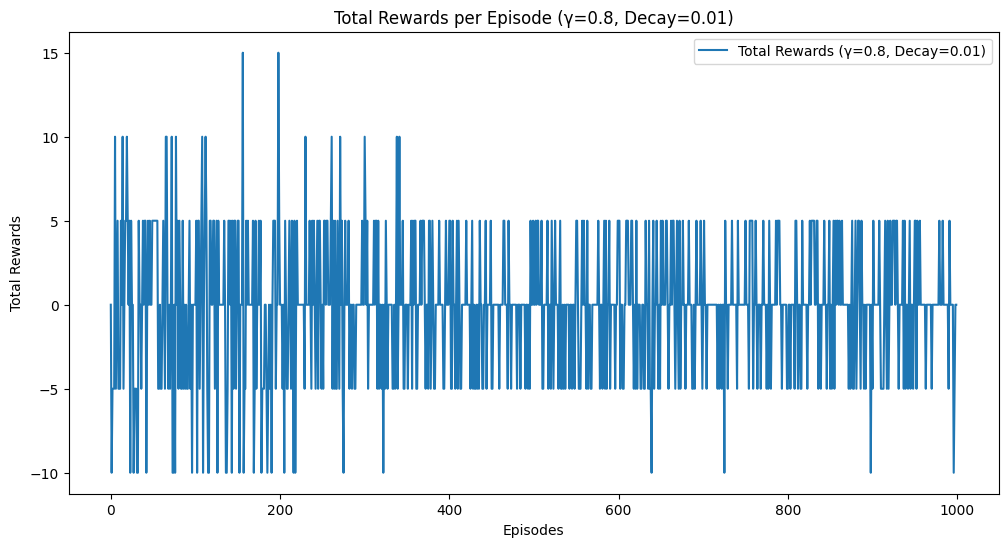

Running SARSA with γ = 0.8 and Decay Rate = 0.02


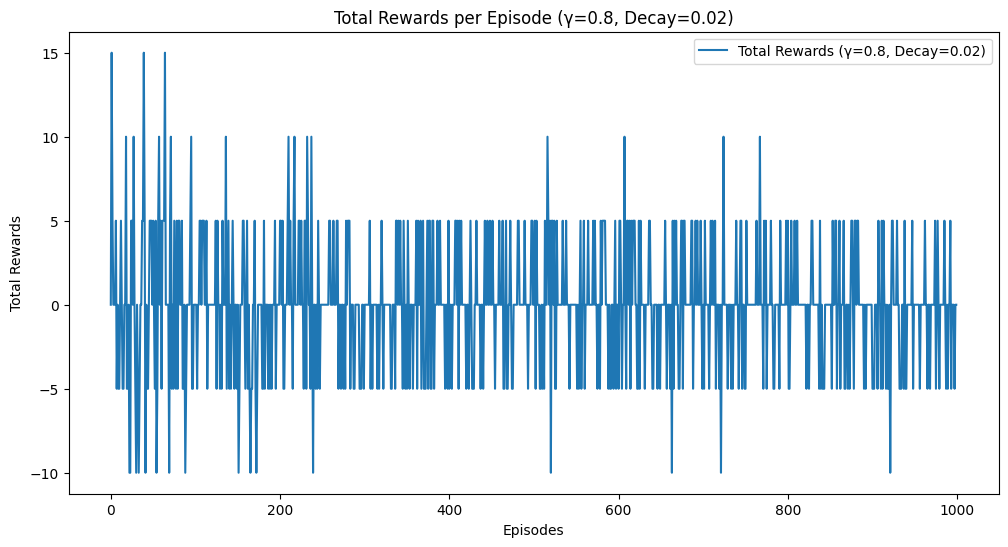

Running SARSA with γ = 0.9 and Decay Rate = 0.005


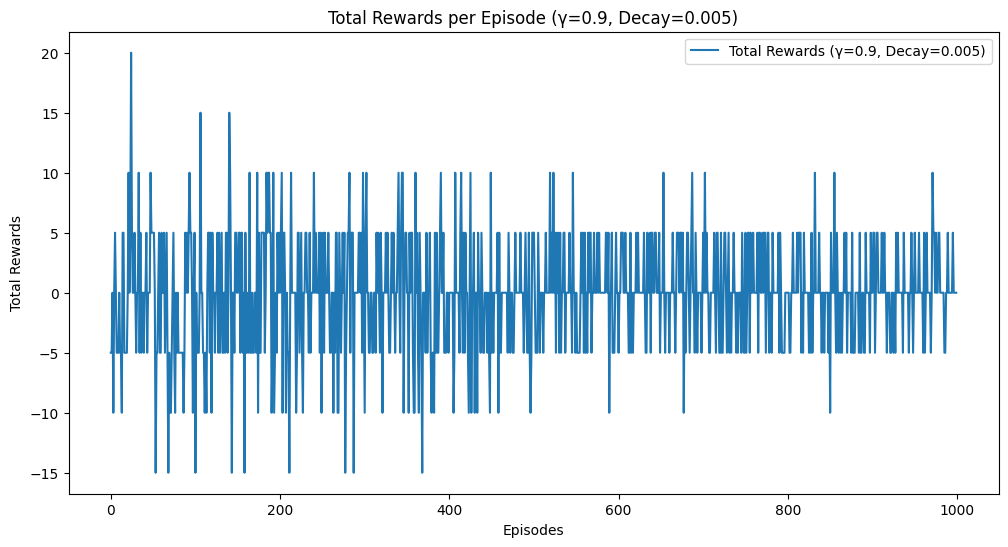

Running SARSA with γ = 0.9 and Decay Rate = 0.01


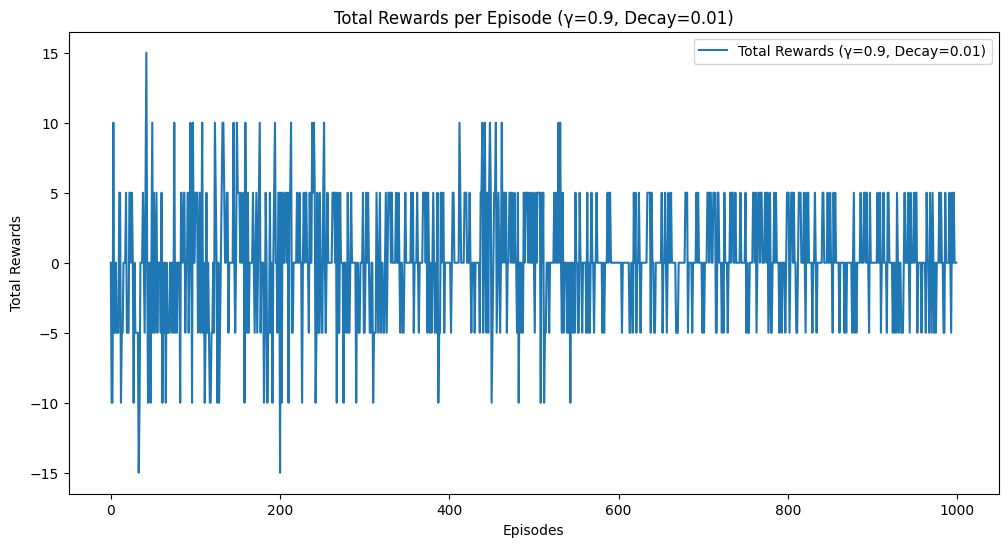

Running SARSA with γ = 0.9 and Decay Rate = 0.02


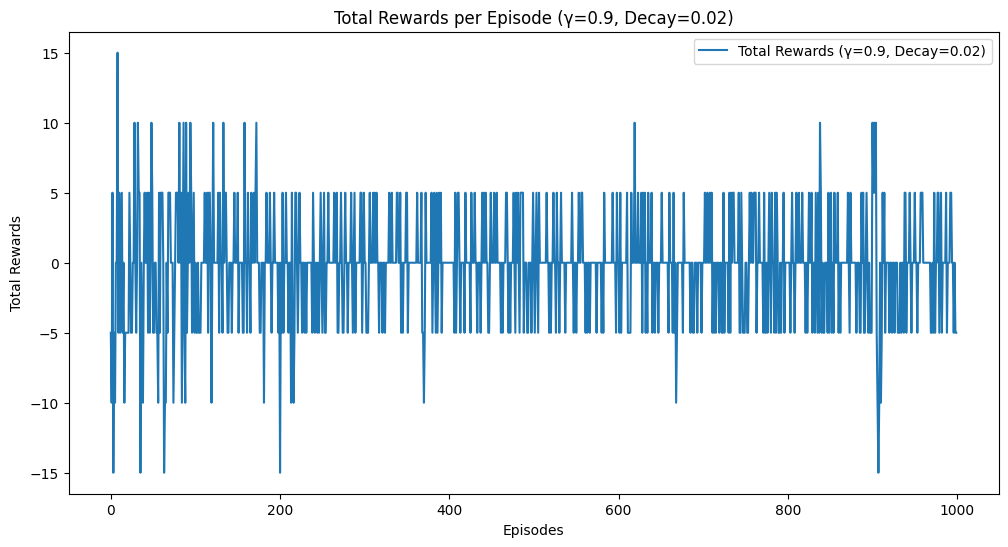

Running SARSA with γ = 0.99 and Decay Rate = 0.005


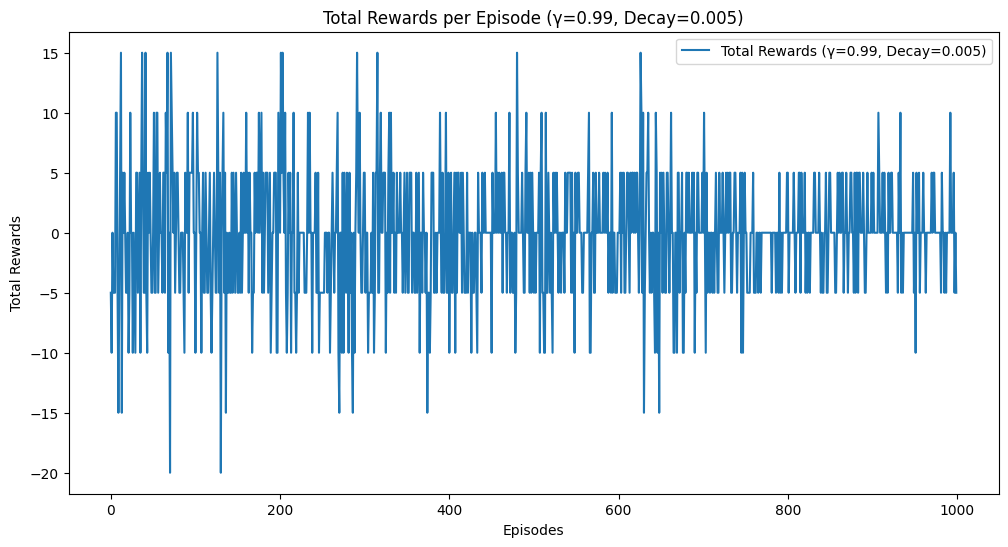

Running SARSA with γ = 0.99 and Decay Rate = 0.01


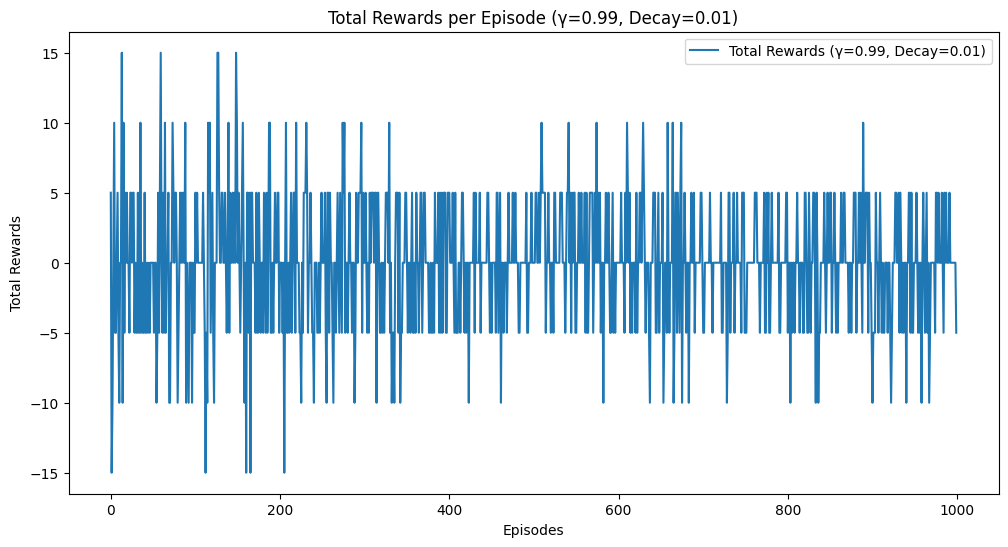

Running SARSA with γ = 0.99 and Decay Rate = 0.02


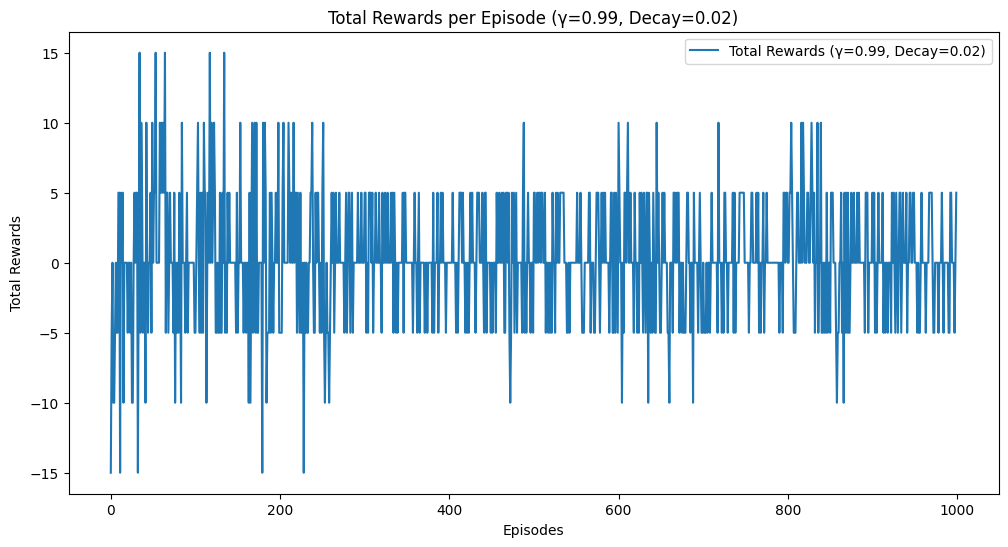

In [13]:
# Define a function to run SARSA with given hyperparameters
def run_sarsa(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))

    total_rewards_history = []
    epsilon_history = []

    for episode in range(total_episodes):
        state = env.reset()
        state_index = np.ravel_multi_index(state, (env.grid_size, env.grid_size))
        step = 0
        done = False
        total_rewards = 0

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_index, :])

        while not done and step < max_steps:
            new_state, reward, done, info = env.step(action)
            new_state_index = np.ravel_multi_index(new_state, (env.grid_size, env.grid_size))
            new_action = np.argmax(q_table[new_state_index, :]) if np.random.uniform(0, 1) > epsilon else env.action_space.sample()

            q_table[state_index, action] += learning_rate * (reward + gamma * q_table[new_state_index, new_action] - q_table[state_index, action])
            total_rewards += reward
            state_index = new_state_index
            action = new_action
            step += 1

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        total_rewards_history.append(total_rewards)
        epsilon_history.append(epsilon)

    return q_table, total_rewards_history, epsilon_history

# Parameters
learning_rate = 0.1
total_episodes = 1000
max_steps = 100
max_epsilon = 1.0
min_epsilon = 0.01

# Hyperparameter Sets
gamma_values = [0.8, 0.9, 0.99]
decay_rate_values = [0.005, 0.01, 0.02]

# Run SARSA with different hyperparameter values and plot results
for gamma in gamma_values:
    for decay_rate in decay_rate_values:
        print(f"Running SARSA with γ = {gamma} and Decay Rate = {decay_rate}")
        q_table, total_rewards_history, epsilon_history = run_sarsa(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(total_rewards_history, label=f'Total Rewards (γ={gamma}, Decay={decay_rate})')
        plt.xlabel('Episodes')
        plt.ylabel('Total Rewards')
        plt.title(f'Total Rewards per Episode (γ={gamma}, Decay={decay_rate})')
        plt.legend()
        plt.show()


## Part III: Implement Double Q-learning
In this part, we apply Double Q-learning algorithm to solve the environment defined in part 1.

In [14]:
def run_double_q_learning(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    Q1 = np.zeros((state_size, action_size))
    Q2 = np.zeros((state_size, action_size))

    total_rewards_history = []
    epsilon_history = []

    for episode in range(total_episodes):
        state = env.reset()
        state_index = np.ravel_multi_index(state, (env.grid_size, env.grid_size))
        total_rewards = 0

        for step in range(max_steps):
            # Epsilon-greedy policy
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q1[state_index, :] + Q2[state_index, :])

            new_state, reward, done, info = env.step(action)
            new_state_index = np.ravel_multi_index(new_state, (env.grid_size, env.grid_size))

            # Update Q1 or Q2 randomly
            if np.random.uniform(0, 1) < 0.5:
                best_next_action = np.argmax(Q1[new_state_index, :])
                Q1[state_index, action] += learning_rate * (reward + gamma * Q2[new_state_index, best_next_action] - Q1[state_index, action])
            else:
                best_next_action = np.argmax(Q2[new_state_index, :])
                Q2[state_index, action] += learning_rate * (reward + gamma * Q1[new_state_index, best_next_action] - Q2[state_index, action])

            total_rewards += reward
            state_index = new_state_index

            if done:
                break

        epsilon = max(epsilon - decay_rate, 0.01)
        total_rewards_history.append(total_rewards)
        epsilon_history.append(epsilon)

    return Q1, Q2, total_rewards_history, epsilon_history

# Initialize the Lawnmower environment
env = LawnmowerEnv(random_grid=True)

# Parameters for Double Q-learning
learning_rate = 0.1
gamma = 0.9
epsilon = 1.0
decay_rate = 0.005
total_episodes = 1000
max_steps = 100

# Run Double Q-learning
Q1, Q2, total_rewards_history, epsilon_history = run_double_q_learning(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)


Trained Q1-table:
[[-2.19285304  0.87333579 -2.77633084 -1.87645497]
 [-1.63335507 -2.21418609 -1.94540865 -0.61512525]
 [-1.4277395  -0.6189752  -1.26729405 -1.43477988]
 [-0.70857563 -0.43459379 -0.75215156 -1.2420681 ]
 [-1.51762703 -2.04036191 -1.02392702 -1.90906921]
 [-1.44655868 -1.38929886  1.2818629  -1.17416523]
 [-0.80095859 -1.13106498 -0.21911777 -0.93558696]
 [-0.46376944 -0.12178481 -0.2614033  -1.02926705]
 [-1.49952705 -1.82309594 -2.26941129 -1.15638626]
 [-0.0437805  -0.4978293  -0.60631458  0.28520613]
 [-0.82157     0.32741177 -0.91031545 -0.42781516]
 [-0.0319551  -0.69827801 -0.21557103 -0.40968947]
 [-0.73080717 -1.0668253  -1.01083521 -1.04413084]
 [-1.13843261 -0.22752099 -0.49088233 -0.61220473]
 [ 0.0405     -0.09466851  0.1283441  -0.46969451]
 [-0.48040781 -0.33485305 -0.32250513  0.88704944]]

Trained Q2-table:
[[-2.25720983  0.26372041 -1.90371107 -2.5068383 ]
 [-1.35533667 -0.95560532 -0.99687263 -2.17915478]
 [-1.03344337 -1.87054794 -1.55056133 -1.106

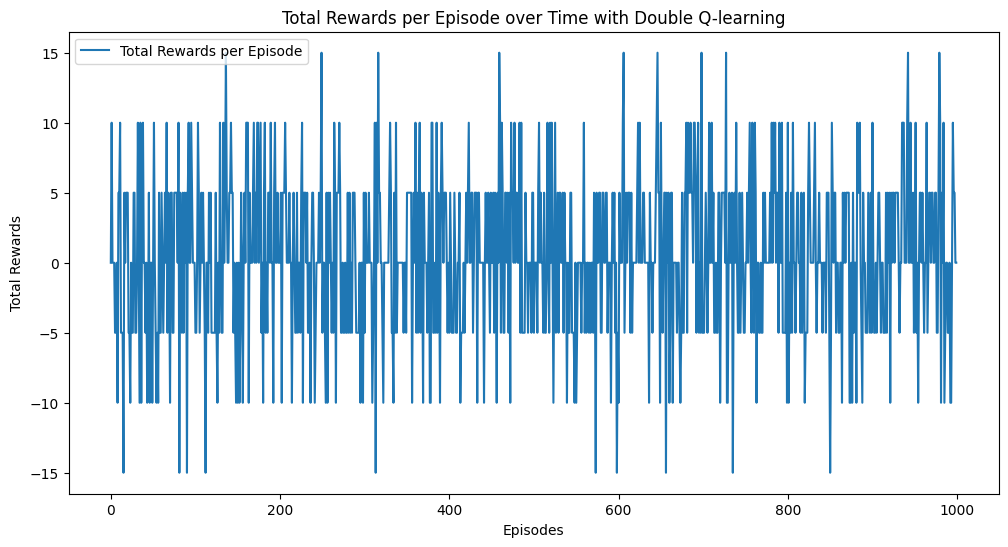

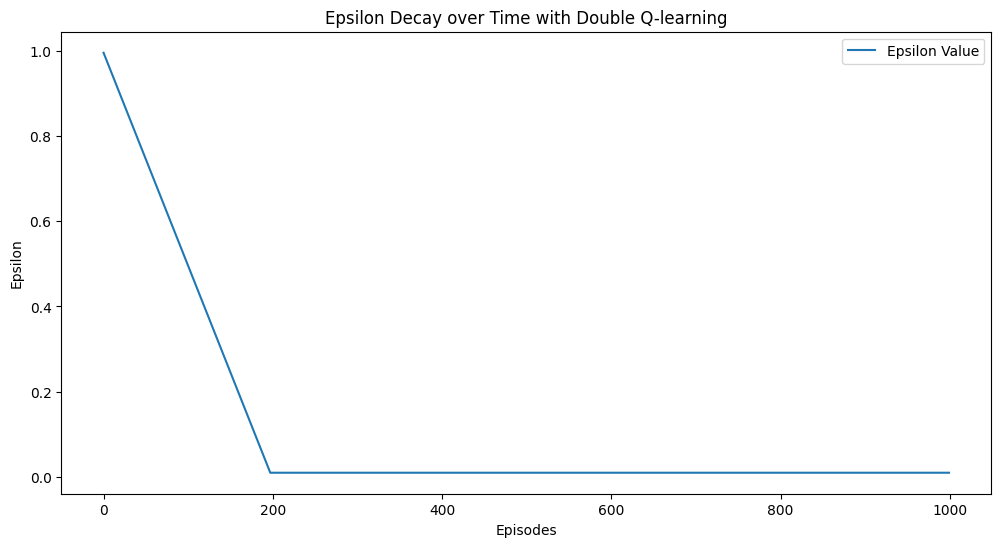

Episode 1: Total Reward = -10.0
Episode 2: Total Reward = -5.0
Episode 3: Total Reward = 5.0
Episode 4: Total Reward = 0.0
Episode 5: Total Reward = 0.0
Episode 6: Total Reward = 0.0
Episode 7: Total Reward = 0.0
Episode 8: Total Reward = 10.0
Episode 9: Total Reward = 0.0
Episode 10: Total Reward = 5.0


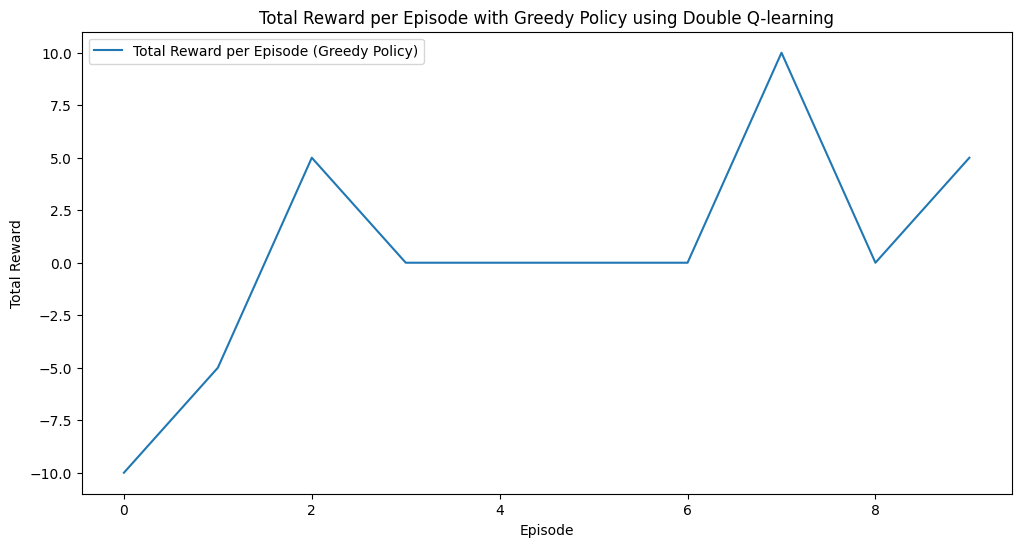

In [15]:
# 1. Print Trained Q-tables
print("Trained Q1-table:")
print(Q1)
print("\nTrained Q2-table:")
print(Q2)

# 2. Plot Total Reward per Episode Graph
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_history, label='Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards per Episode over Time with Double Q-learning')
plt.legend()
plt.show()

# 3. Plot Epsilon Decay Graph
plt.figure(figsize=(12, 6))
plt.plot(epsilon_history, label='Epsilon Value')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Time with Double Q-learning')
plt.legend()
plt.show()

# 4. Greedy Policy Evaluation
greedy_total_rewards = []
for episode in range(10):
    state = env.reset()
    state_index = np.ravel_multi_index(state, (env.grid_size, env.grid_size))
    total_reward = 0

    for step in range(max_steps):
        action = np.argmax(Q1[state_index, :] + Q2[state_index, :])  # Greedy action
        new_state, reward, done, _ = env.step(action)
        new_state_index = np.ravel_multi_index(new_state, (env.grid_size, env.grid_size))
        
        total_reward += reward
        state_index = new_state_index

        if done:
            break

    greedy_total_rewards.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward}")

# Plotting total rewards for greedy policy evaluation
plt.figure(figsize=(12, 6))
plt.plot(greedy_total_rewards, label='Total Reward per Episode (Greedy Policy)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode with Greedy Policy using Double Q-learning')
plt.legend()
plt.show()


In [16]:
def tune_hyperparameters(env, learning_rate, gamma_values, epsilon_decay_values, total_episodes, max_steps):
    tuning_results = {}
    
    for gamma in gamma_values:
        for decay_rate in epsilon_decay_values:
            Q1, Q2, rewards_history, _ = run_double_q_learning(env, learning_rate, gamma, 1.0, decay_rate, total_episodes, max_steps)
            tuning_results[(gamma, decay_rate)] = {
                "Q1": Q1,
                "Q2": Q2,
                "Rewards": rewards_history
            }
    
    return tuning_results

# Hyperparameter values to try
gamma_values = [0.8, 0.9, 0.99]
epsilon_decay_values = [0.005, 0.01, 0.02]

# Running the tuning
env = LawnmowerEnv(random_grid=True)
learning_rate = 0.1
total_episodes = 1000
max_steps = 100

tuning_results = tune_hyperparameters(env, learning_rate, gamma_values, epsilon_decay_values, total_episodes, max_steps)


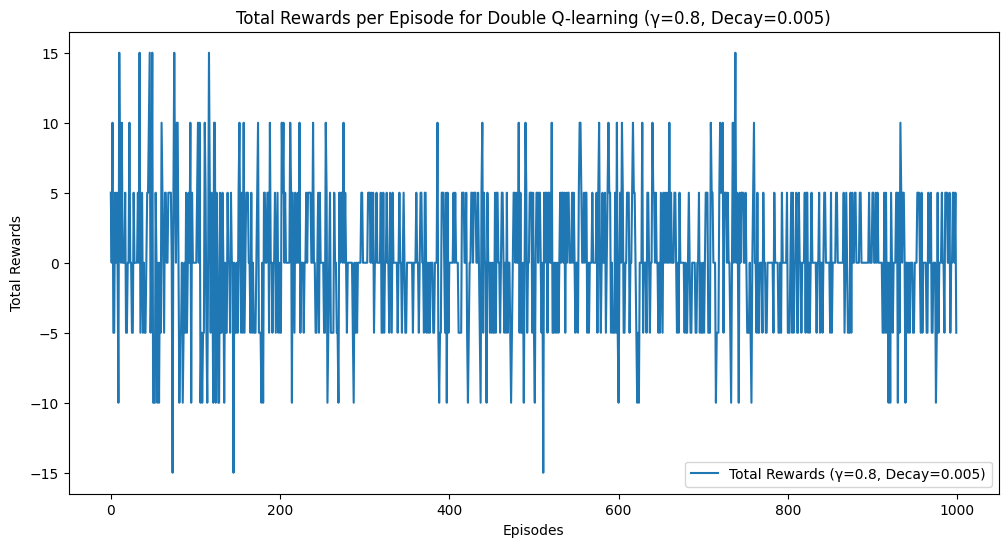

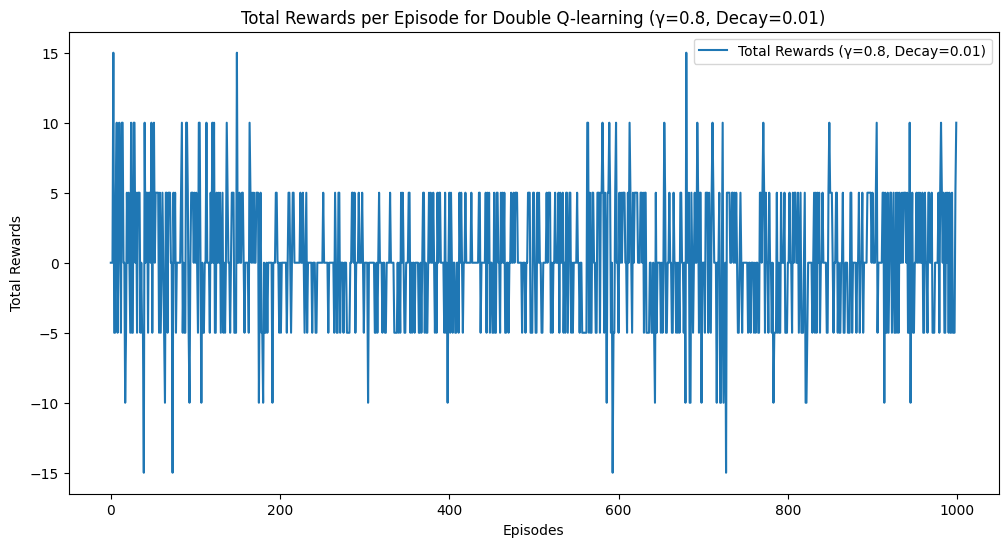

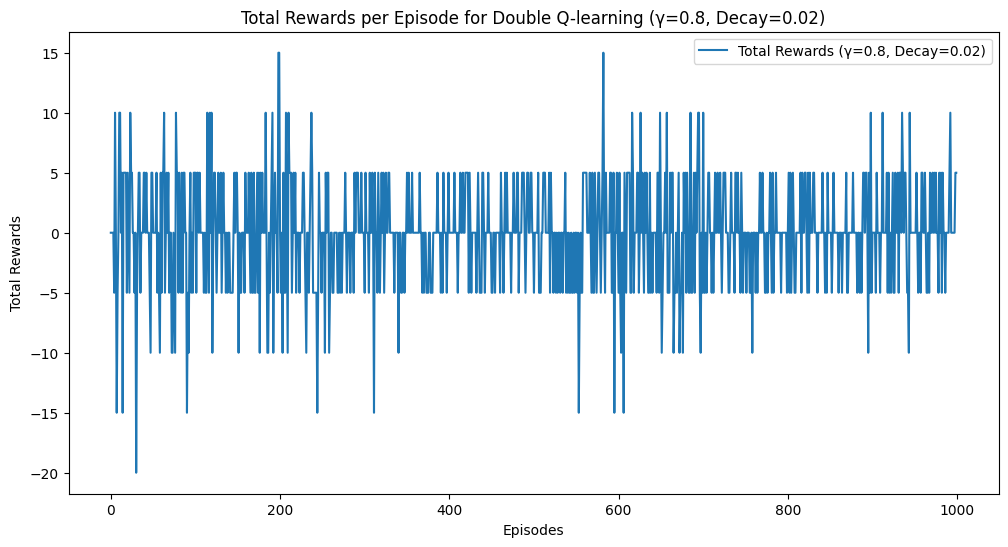

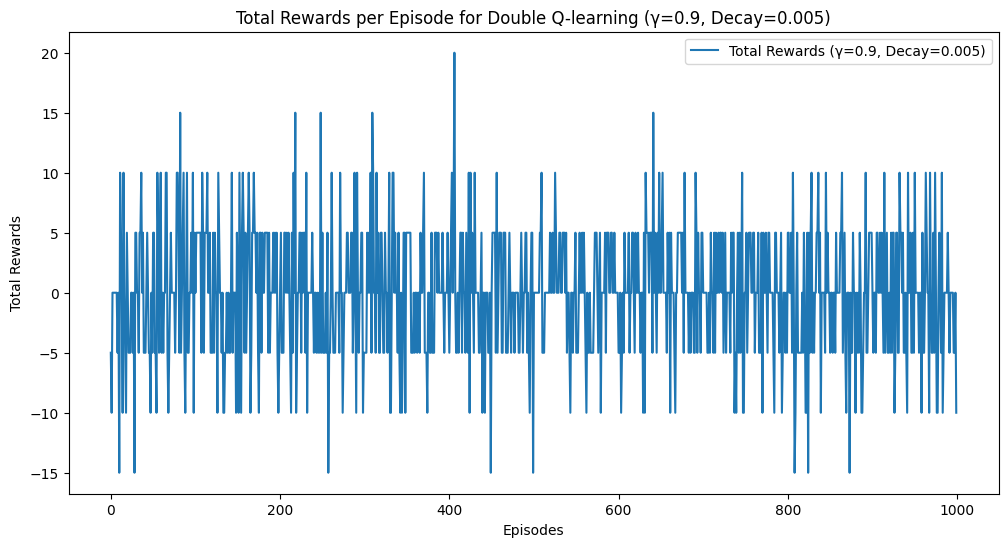

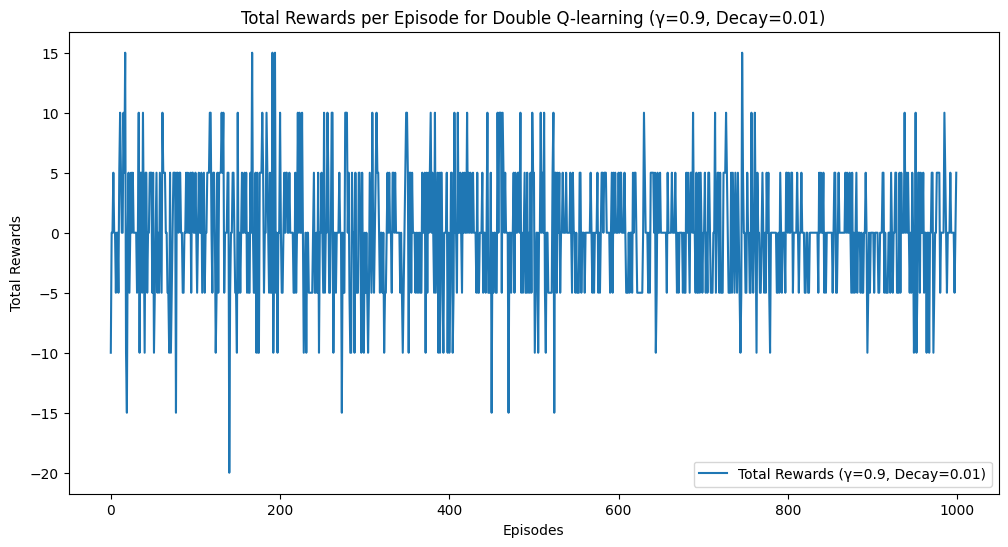

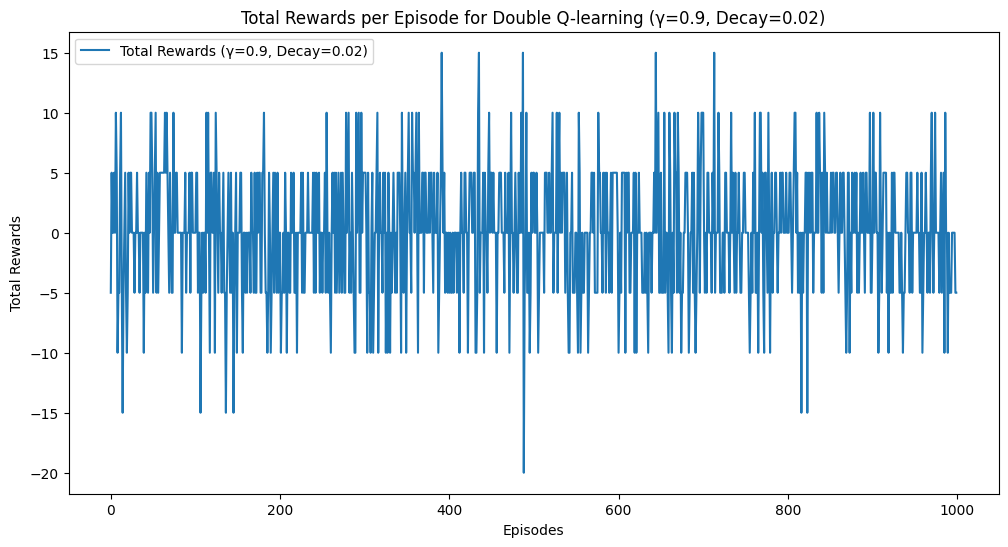

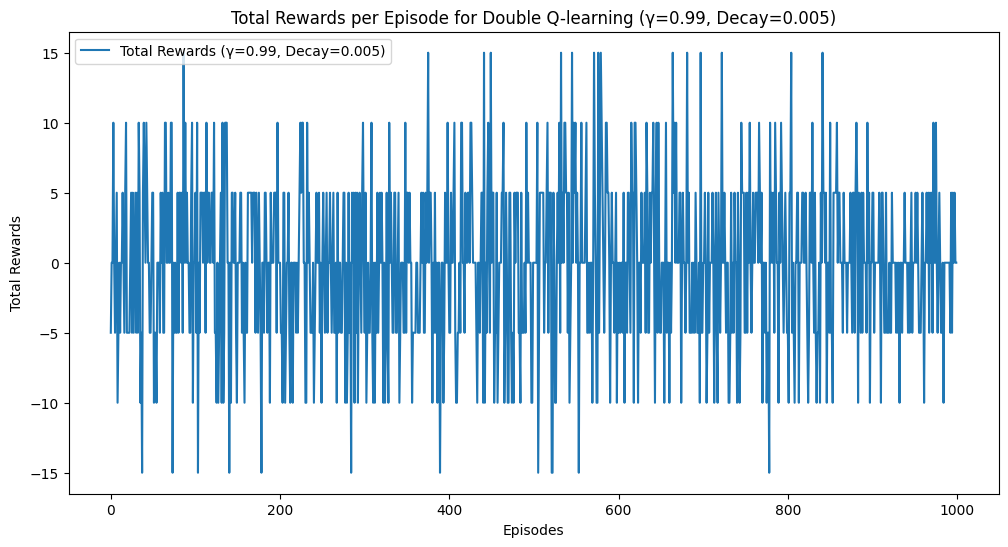

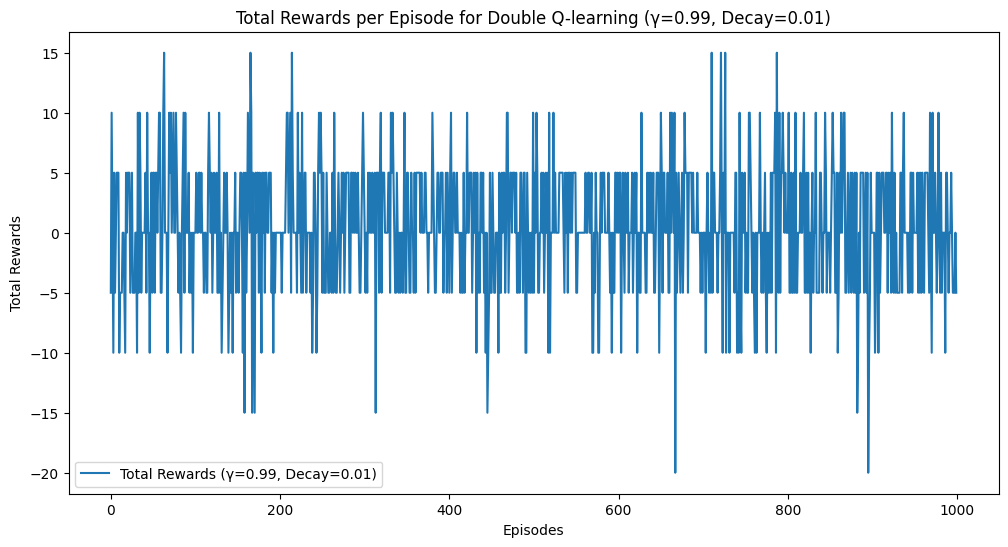

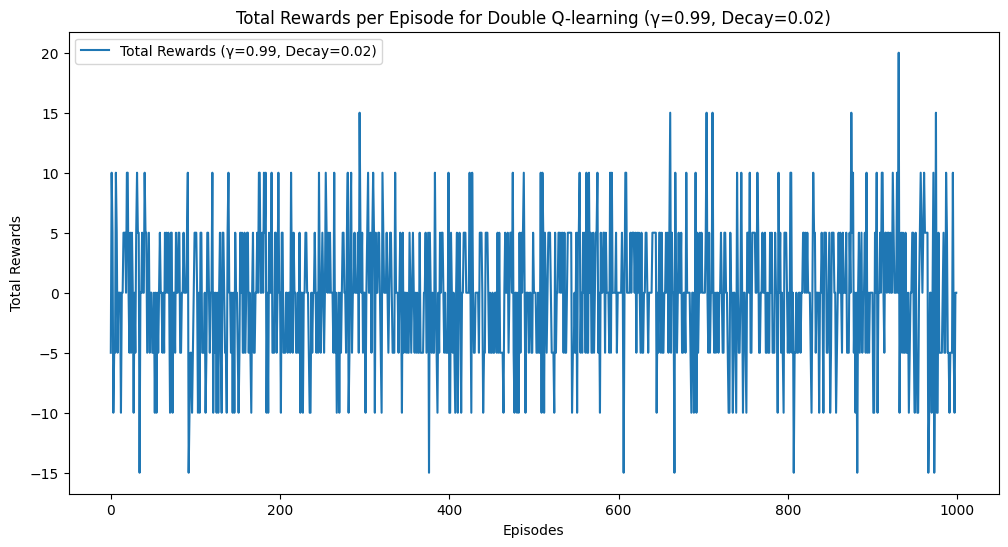

In [17]:

for (gamma, decay_rate), data in tuning_results.items():
    rewards_history = data['Rewards']
    
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, label=f'Total Rewards (γ={gamma}, Decay={decay_rate})')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title(f'Total Rewards per Episode for Double Q-learning (γ={gamma}, Decay={decay_rate})')
    plt.legend()
    plt.show()


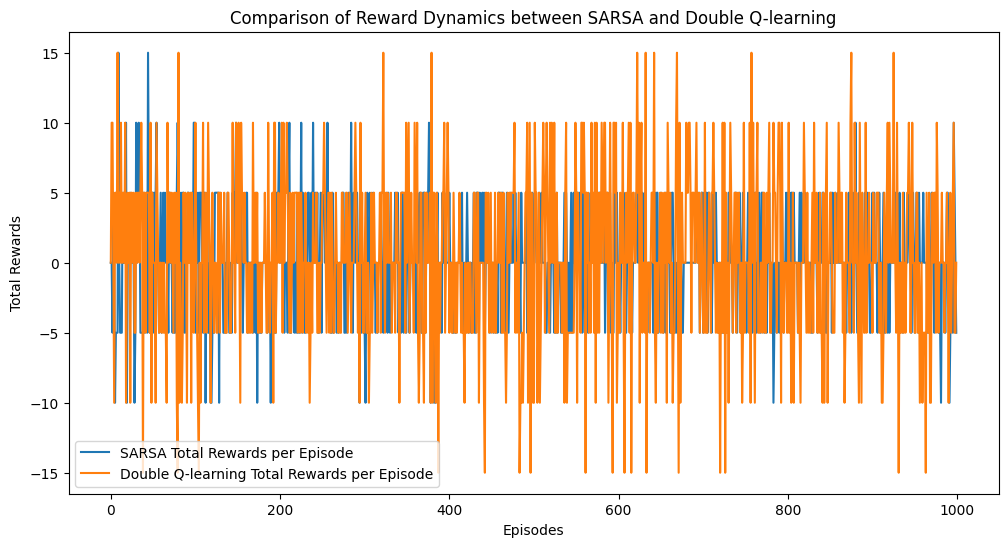

In [18]:
# Run SARSA
sarsa_q_table, sarsa_rewards_history, _ = run_sarsa(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)

# Run Double Q-learning
double_q_Q1, double_q_Q2, double_q_rewards_history, _ = run_double_q_learning(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)

# Generate the comparison plot
plt.figure(figsize=(12, 6))
plt.plot(sarsa_rewards_history, label='SARSA Total Rewards per Episode')
plt.plot(double_q_rewards_history, label='Double Q-learning Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Comparison of Reward Dynamics between SARSA and Double Q-learning')
plt.legend()
plt.show()


## BONUS: n-step Bootstrapping
In this section we implemented 2-step SARSA by modifying a base SARSA algorithm.

In [19]:
def run_n_step_sarsa(env, n, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))

    total_rewards_history = []

    for episode in range(total_episodes):
        state = env.reset()
        state_index = np.ravel_multi_index(state, (env.grid_size, env.grid_size))
        total_rewards = 0
        states = [state_index]
        rewards = [0]
        actions = []

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_index, :])
        actions.append(action)

        for step in range(max_steps):
            new_state, reward, done, info = env.step(action)
            new_state_index = np.ravel_multi_index(new_state, (env.grid_size, env.grid_size))

            if np.random.uniform(0, 1) < epsilon:
                new_action = env.action_space.sample()
            else:
                new_action = np.argmax(q_table[new_state_index, :])

            states.append(new_state_index)
            rewards.append(reward)
            actions.append(new_action)

            if step >= n:
                G = sum([gamma ** (i - step - 1) * rewards[i] for i in range(step - n + 1, step + 1)])
                if not done:
                    G += (gamma ** n) * q_table[states[step - n + 1], actions[step - n + 1]]
                q_table[states[step - n], actions[step - n]] += learning_rate * (G - q_table[states[step - n], actions[step - n]])

            total_rewards += reward
            if done:
                break
            action = new_action

        epsilon = max(epsilon - decay_rate, 0.01)
        total_rewards_history.append(total_rewards)

    return q_table, total_rewards_history


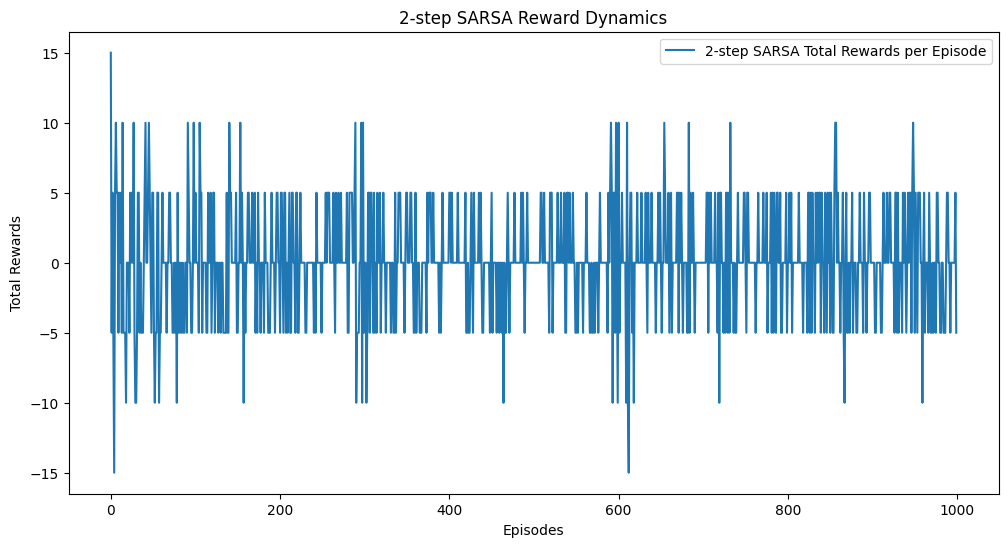

In [20]:
# Parameters for n-step SARSA
n_step = 2  

# Run n-step SARSA
n_step_sarsa_q_table, n_step_sarsa_rewards_history = run_n_step_sarsa(env, n_step, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)

# Plotting for n-step SARSA
plt.figure(figsize=(12, 6))
plt.plot(n_step_sarsa_rewards_history, label=f'{n_step}-step SARSA Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title(f'{n_step}-step SARSA Reward Dynamics')
plt.legend()
plt.show()


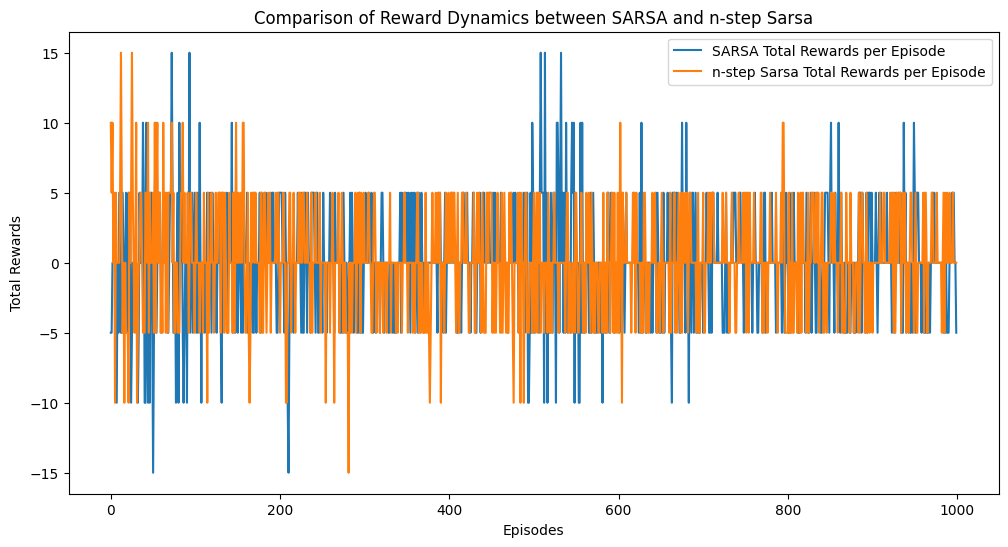

In [21]:
# Run SARSA
sarsa_q_table, sarsa_rewards_history, _ = run_sarsa(env, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)

# Run n-step SARSA
n_step_sarsa_q_table, n_step_sarsa_rewards_history = run_n_step_sarsa(env, n_step, learning_rate, gamma, epsilon, decay_rate, total_episodes, max_steps)

# Generate the comparison plot
plt.figure(figsize=(12, 6))
plt.plot(sarsa_rewards_history, label='SARSA Total Rewards per Episode')
plt.plot(n_step_sarsa_rewards_history, label='n-step Sarsa Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Comparison of Reward Dynamics between SARSA and n-step Sarsa')
plt.legend()
plt.show()
